In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt

from util import ScoreDistribution, ROC_AUC, \
    prob_scale, get_resampling, PSI, xgbCV

In [2]:
# ! ls -la ../../dataset/

In [3]:
# df_treino = pd.read_csv('../../dataset/cs-training.csv')
df_treino = pd.read_csv('cs-training.csv')
df_treino.drop(columns='Unnamed: 0', inplace=True)
df_treino.rename(columns={'SeriousDlqin2yrs':'target'}, inplace=True)
df_treino.target = df_treino.target.apply(lambda target: 1 if target==0 else 0)
print(df_treino.dtypes)

target                                    int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object


In [4]:
df_treino

,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,1,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,1,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,1,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,1,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,1,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,1,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,1,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


<AxesSubplot:>

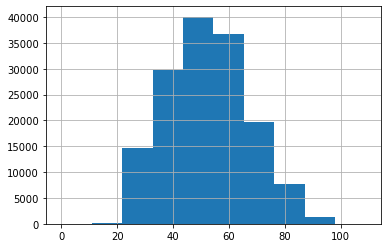

In [5]:
df_treino['age'].hist()

In [6]:
df_treino[df_treino['age']<25]

,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
28,1,0.452516,24,0,0.011761,3400.0,1,0,0,0,0.0
31,1,1.000000,24,0,0.472703,750.0,1,0,0,0,0.0
255,1,0.000000,23,0,0.000000,1725.0,1,0,0,0,0.0
381,1,1.000000,22,0,130.000000,NaN,0,0,0,0,NaN
425,1,0.971352,24,0,0.035803,1200.0,3,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149571,1,0.039017,22,0,0.208306,1540.0,7,0,0,0,0.0
149645,1,1.000000,24,0,29.000000,NaN,2,0,0,0,NaN
149686,1,0.000000,21,0,0.082796,929.0,1,0,0,0,0.0
149769,1,1.000000,23,98,0.000000,NaN,0,98,0,98,NaN


In [7]:
df_treino[df_treino['age']<25].age.min(), df_treino[df_treino['age']<25].age.max()

(0, 24)

In [8]:
df_treino[df_treino['age']<25].age.mean()

22.996626506024096

In [9]:
df_treino['target'].value_counts()

1    139974
0     10026
Name: target, dtype: int64

In [10]:
df_treino['target'].value_counts(normalize=True)

1    0.93316
0    0.06684
Name: target, dtype: float64

<AxesSubplot:>

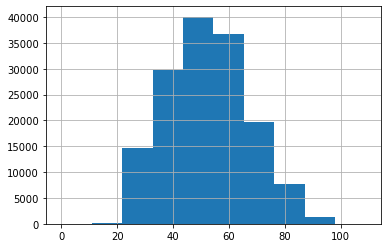

In [11]:
df_treino['age'].hist()

In [12]:
df_jovens = df_treino[df_treino['age']<40]
df_adultos = df_treino[(df_treino['age']>=40) & (df_treino['age']<60)]
df_idosos = df_treino[(df_treino['age']>=60)]

In [13]:
df_jovens.shape, df_adultos.shape, df_idosos.shape

((32004, 11), (69678, 11), (48318, 11))

In [14]:
df_jovens['target'].value_counts(normalize=True)

1    0.894701
0    0.105299
Name: target, dtype: float64

In [15]:
df_adultos['target'].value_counts(normalize=True)

1    0.926002
0    0.073998
Name: target, dtype: float64

In [16]:
df_idosos['target'].value_counts(normalize=True)

1    0.968956
0    0.031044
Name: target, dtype: float64

# Preparação dos dados

In [17]:
df_treino['MonthlyIncome'] = np.log(1+df_treino['MonthlyIncome'].values)
df_treino['NumberOfDependents'] = np.log(1+df_treino['NumberOfDependents'].values)

df_treino['MonthlyIncome_Null'] = pd.isnull(df_treino['MonthlyIncome'])
df_treino['NoD_Null'] = pd.isnull(df_treino['NumberOfDependents'])

df_treino.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
df_treino.reset_index()

df_treino['IncomePerPerson'] = df_treino['MonthlyIncome']/\
    (df_treino['NumberOfDependents']+1)
df_treino['NumOfPastDue'] = \
    df_treino['NumberOfTimes90DaysLate']+\
    df_treino['NumberOfTime60-89DaysPastDueNotWorse']+\
    df_treino['NumberOfTime30-59DaysPastDueNotWorse']
df_treino['MonthlyDebt'] = df_treino['DebtRatio']*df_treino['MonthlyIncome']
df_treino['NumOfOpenCreditLines'] = df_treino['NumberOfOpenCreditLinesAndLoans']-\
    df_treino['NumberRealEstateLoansOrLines']
df_treino['MonthlyBalance'] = df_treino['MonthlyIncome']-df_treino['MonthlyDebt']

# Continua...

## remove outlier
df_treino = df_treino[df_treino['age'] != 0]
df_treino = df_treino[df_treino['age'] !=99]
df_treino = df_treino[df_treino['age'] !=101]

# NaN - média() - 850 - Score 900 - NaN==1 Score == 110
# Zero - Zero

## create new features
df_treino['age_sqr'] = df_treino['age'].values^2 
## apply the same operation on testing set
df_treino['age_sqr'] = df_treino['age'].values^2

df_treino.drop(['MonthlyIncome_Null','NoD_Null'],axis=1,inplace=True)

In [18]:
df_treino.shape

(146067, 17)

# Modelagem

In [19]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_treino.drop(columns='target'), 
                     df_treino['target'], 
                     test_size=0.33, random_state=42)

In [20]:
train = xgb.DMatrix(X_train,y_train,feature_names=X_train.columns)
test = xgb.DMatrix(X_test,feature_names=X_test.columns)
xgb_params = {
    'eta':0.03,
    'max_depth':4,
    'sub_sample':0.9,
    'colsample_bytree':0.5,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'silent':0}

final_model = xgb.train(xgb_params,train,num_boost_round=500)

[16:50:05] WARNING: ../src/learner.cc:573: 
Parameters: { "silent", "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [21]:
df_treino['target'].value_counts(normalize=True)

1    0.932599
0    0.067401
Name: target, dtype: float64

In [22]:
y_train.value_counts(normalize=True)

1    0.932784
0    0.067216
Name: target, dtype: float64

In [23]:
y_test.value_counts(normalize=True)

1    0.932224
0    0.067776
Name: target, dtype: float64

In [24]:
X_train.shape

(97864, 16)

In [25]:
X_test.shape

(48203, 16)

# Avaliação

In [26]:
y_pred_train = final_model.predict(train)
y_pred_train

array([0.33894035, 0.97073317, 0.98952127, ..., 0.44159847, 0.9872171 ,
       0.99307513], dtype=float32)

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:692: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random')


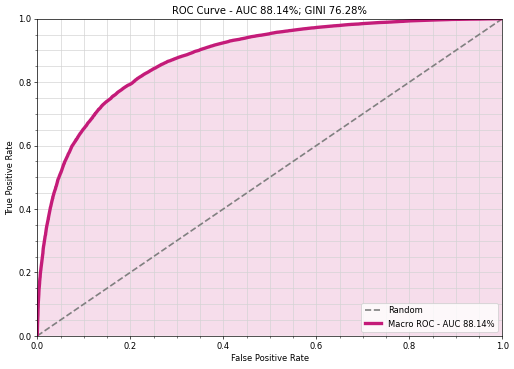

In [27]:
roc_auc_train = ROC_AUC(y_pred_train, y_train)
roc_auc_train.plot()

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


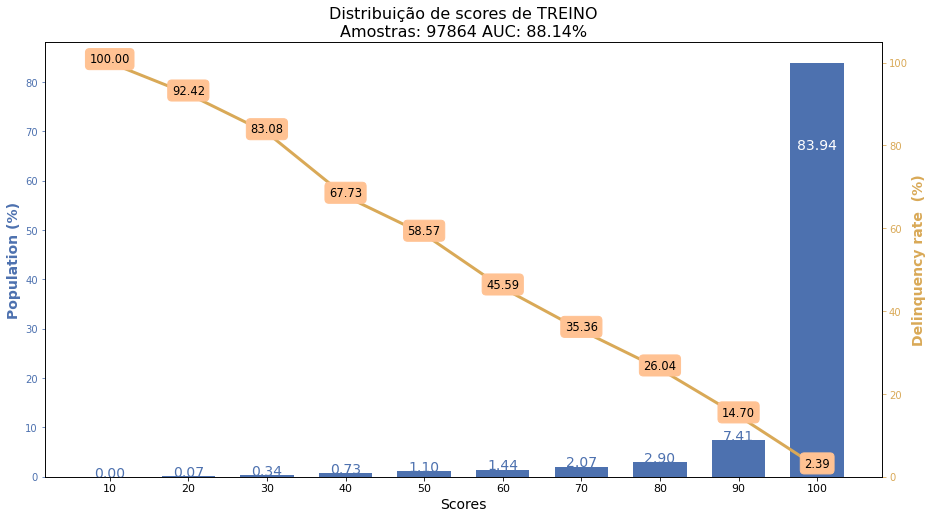

In [29]:
title_train = 'Distribuição de scores de TREINO\nAmostras: %d AUC: %.2f%%'%\
    (len(y_train), roc_auc_train.value*100)
ScoreDistribution(y_pred_train, y_train).plot(title=title_train)

In [30]:
y_pred = final_model.predict(test)
y_pred

array([0.99642247, 0.9735101 , 0.9205035 , ..., 0.99105036, 0.8904794 ,
       0.927555  ], dtype=float32)

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:692: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random')


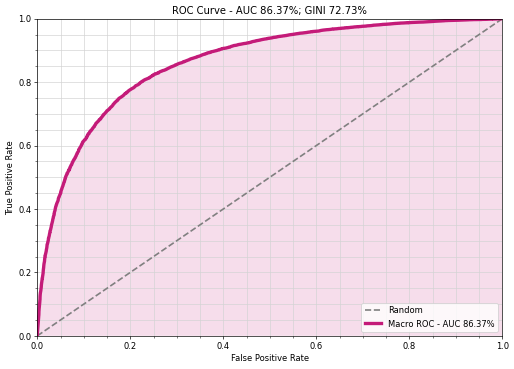

In [34]:
roc_auc_test = ROC_AUC(y_pred, y_test)
roc_auc_test.plot()

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


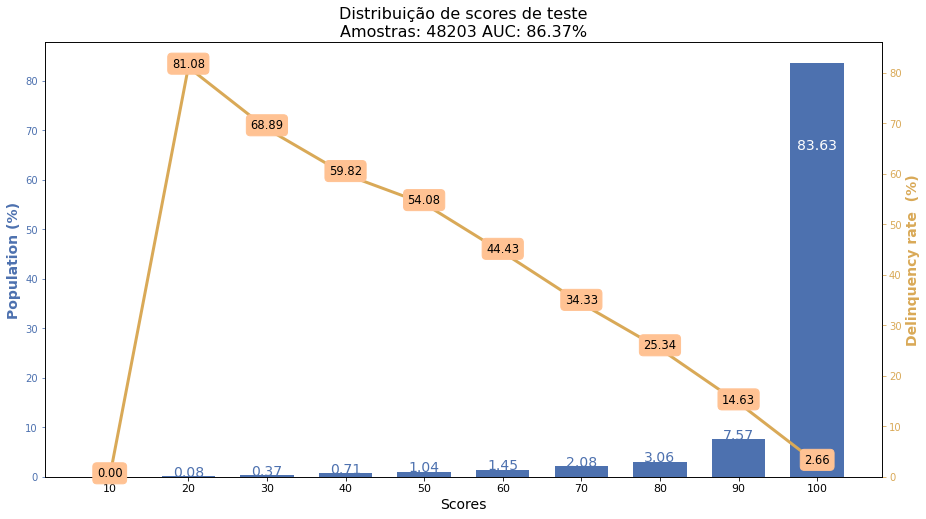

In [35]:
title_test = 'Distribuição de scores de teste\nAmostras: %d AUC: %.2f%%'%\
    (len(y_test), roc_auc_test.value*100)
ScoreDistribution(y_pred, y_test).plot(title=title_test)

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


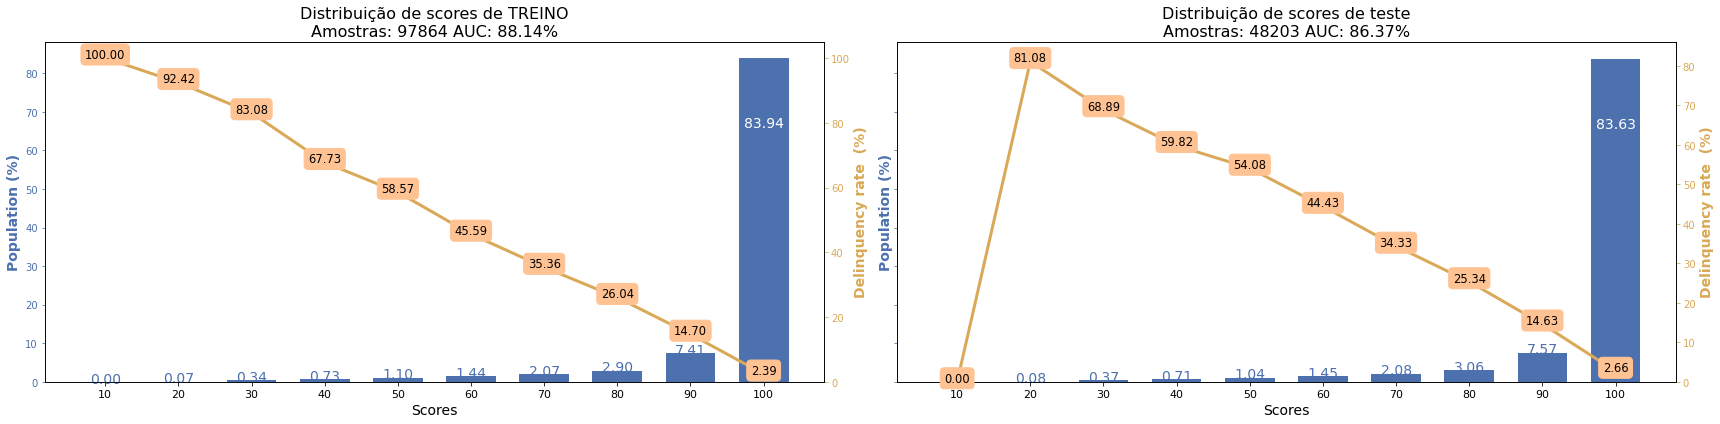

In [36]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred_train, y_train).plot(ax=axis[0], title=title_train)
ScoreDistribution(y_pred, y_test).plot(ax=axis[1], title=title_test)
plt.tight_layout()
plt.show()

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:433: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ], {'size': fontsize - 2})


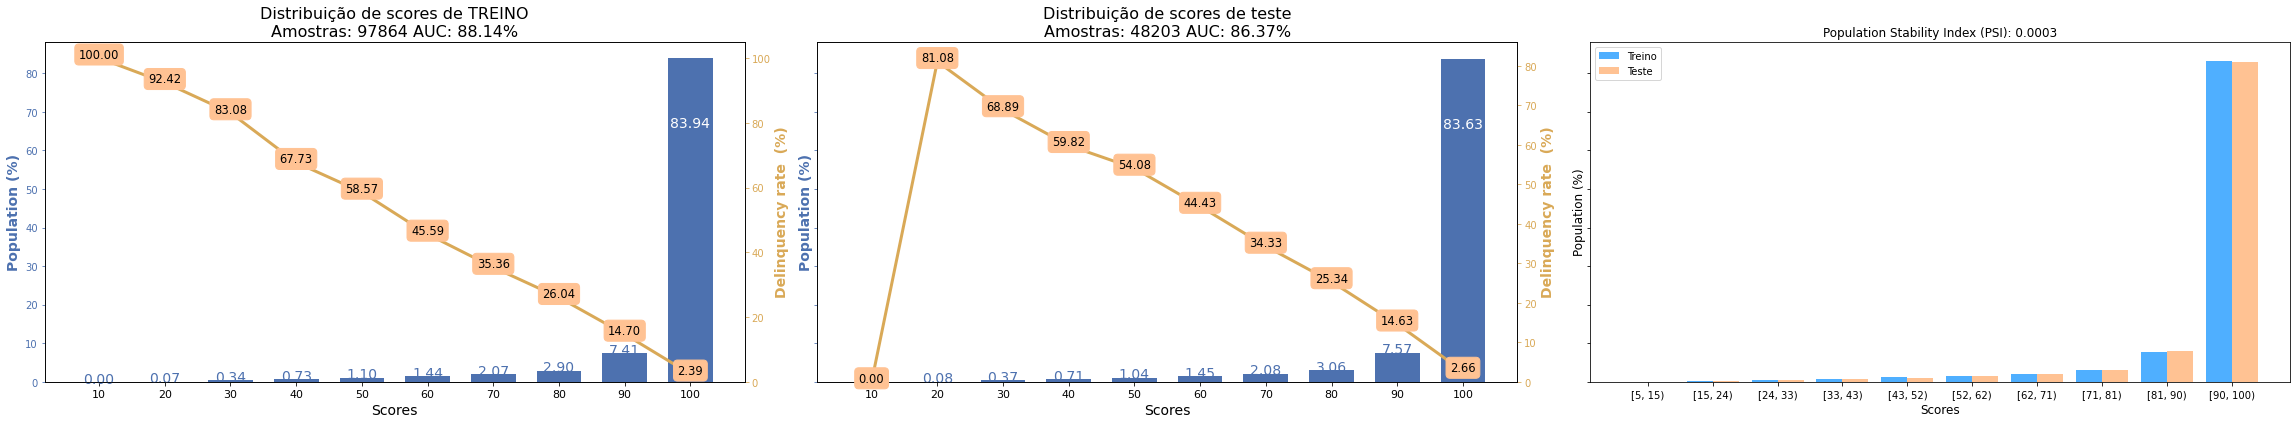

In [37]:
fig, axis = plt.subplots(1, 3, figsize=(32, 6), sharey=True)
ScoreDistribution(y_pred_train, y_train).plot(ax=axis[0], title=title_train)
ScoreDistribution(y_pred, y_test).plot(ax=axis[1], title=title_test)
PSI(y_pred_train, y_pred).plot('Treino', 'Teste', ax=axis[2])
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Population Stability Index (PSI): 0.0003'}, xlabel='Scores', ylabel='Population (%)'>

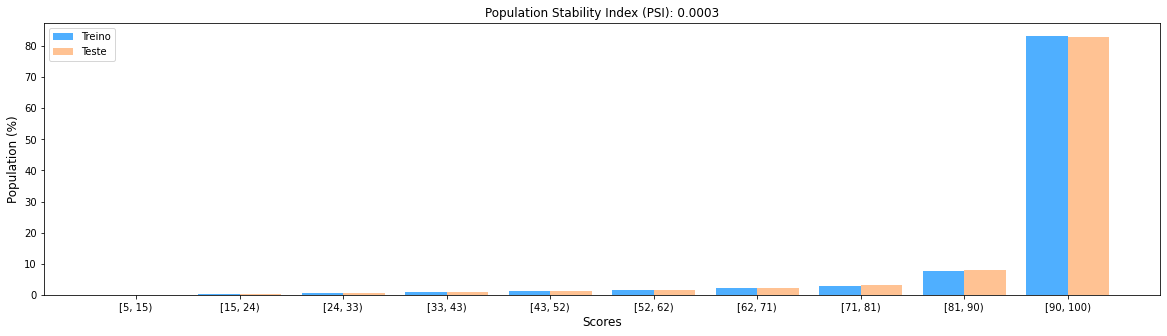

In [38]:
PSI(y_pred_train, y_pred).plot('Treino', 'Teste')

# Desbalanceada
- Balanceamento
- * Undersampling
    -- Diminuir a importancia da classe majoritaria (BOM)
    -- Todas MAU
    -- Amostras BOM = len(MAU)
- * Oversampling
    -- Aumentar a importancia da classe minoritaria (MAU)
    -- Todas BOM
    -- MAU = len(BOM) - len(MAU)
        -- Random: sorteios
        -- ADASYN
        -- SMOTE

In [39]:
df_treino.target.value_counts(normalize=True)

1    0.932599
0    0.067401
Name: target, dtype: float64

In [40]:
df_treino.target.value_counts()

1    136222
0      9845
Name: target, dtype: int64

In [41]:
9845 * 2

19690

In [42]:
X_train_under, y_train_under = get_resampling(X_train, y_train, 
                                              verbose=False, 
                                              random_state=42, 
                                              by='undersampling', 
                                              good_mult=1)

In [43]:
y_train_under.value_counts(normalize=True)

0    0.5
1    0.5
Name: bom_pagador, dtype: float64

In [44]:
y_train_under.value_counts()

0    6578
1    6578
Name: bom_pagador, dtype: int64

In [45]:
train = xgb.DMatrix(X_train_under,y_train_under,
                    feature_names=X_train_under.columns)
test = xgb.DMatrix(X_test,feature_names=X_train_under.columns)
xgb_params = {
                    'eta':0.03,
                    'max_depth':4,
                    'sub_sample':0.9,
                    'colsample_bytree':0.5,
                    'objective':'binary:logistic',
                    'eval_metric':'auc',
                    'silent':0
                    }

final_model_under = xgb.train(xgb_params,train,num_boost_round=500)

[17:01:33] WARNING: ../src/learner.cc:573: 
Parameters: { "silent", "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




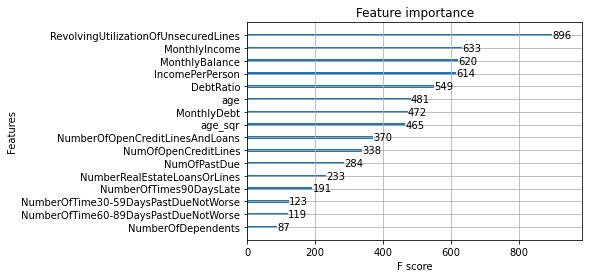

In [46]:
y_pred_train_under = final_model_under.predict(train)

xgb.plot_importance(final_model_under)
plt.show()

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:692: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random')


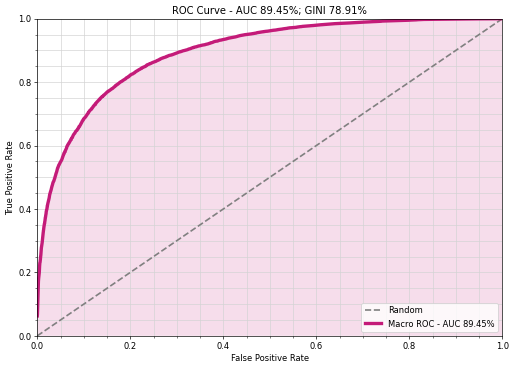

In [47]:
roc_auc_train_under = ROC_AUC(y_pred_train_under, y_train_under)
roc_auc_train_under.plot()

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


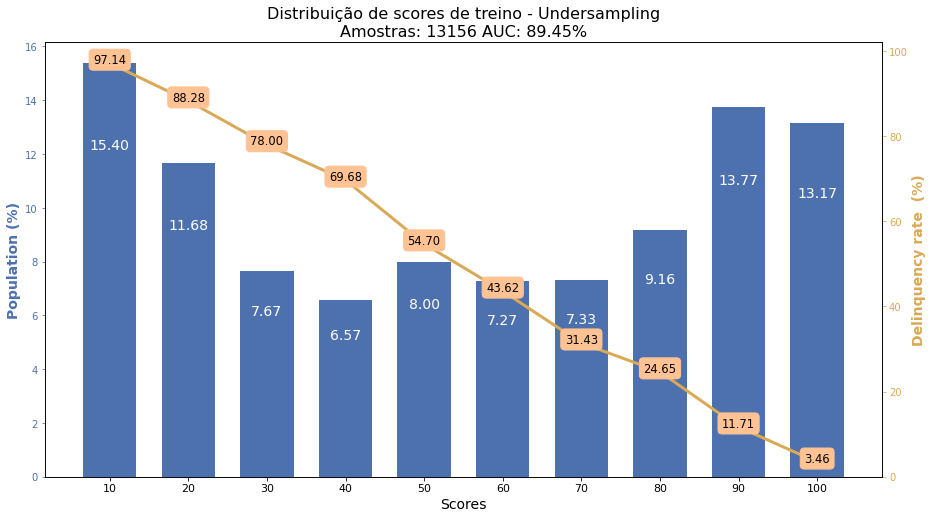

In [48]:
title_train_under = 'Distribuição de scores de treino - Undersampling\nAmostras: %d AUC: %.2f%%'%\
    (len(y_train_under), roc_auc_train_under.value*100)
ScoreDistribution(y_pred_train_under, y_train_under).plot(title=title_train_under)

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:692: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random')


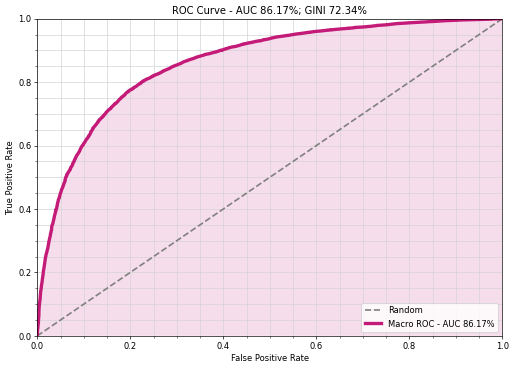

In [49]:
y_pred_under = final_model_under.predict(test)

roc_auc_test_under = ROC_AUC(y_pred_under, y_test)
roc_auc_test_under.plot()

In [50]:
X_test.head(2)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerPerson,NumOfPastDue,MonthlyDebt,NumOfOpenCreditLines,MonthlyBalance,age_sqr
44144,0.064525,71,0,1591.000000,NaN,6,0,1,0,0.0,NaN,0,NaN,5,NaN,69
8267,0.170445,34,0,0.525246,8.699681,9,0,2,0,0.0,8.699681,0,4.569471,7,4.13021,32


In [56]:
y_pred_under[:2]

array([0.9621924 , 0.69562346], dtype=float32)

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


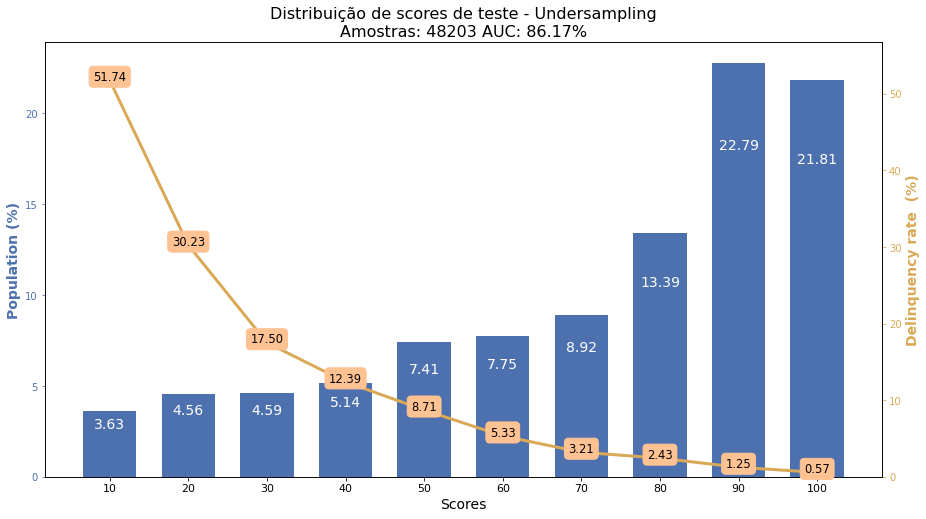

In [51]:
title_test_under = 'Distribuição de scores de teste - Undersampling\nAmostras: %d AUC: %.2f%%'%\
    (len(y_pred_under), roc_auc_test_under.value*100)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under)

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:433: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ], {'size': fontsize - 2})


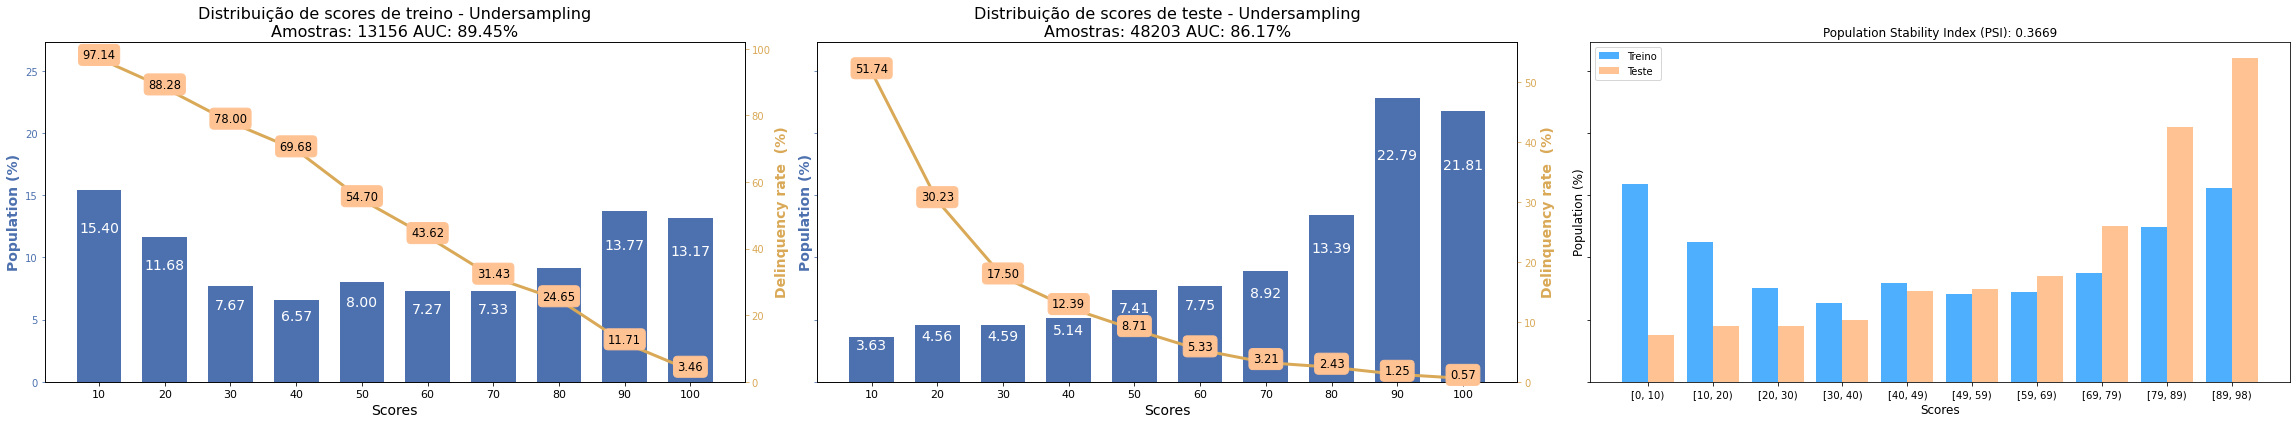

In [52]:
fig, axis = plt.subplots(1, 3, figsize=(32, 6), sharey=True)
ScoreDistribution(y_pred_train_under, y_train_under).plot(ax=axis[0],title=title_train_under)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under, ax=axis[1])
PSI(y_pred_train_under, y_pred_under).plot('Treino', 'Teste', ax=axis[2])
plt.tight_layout()
plt.show()

# Comparação de modelos

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


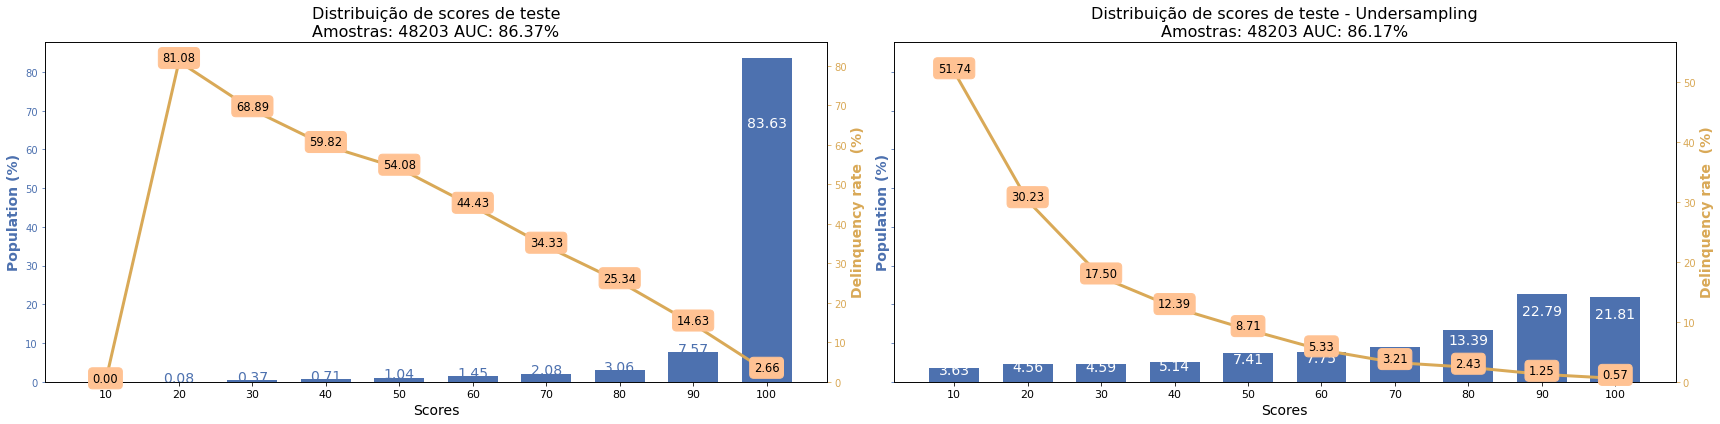

In [53]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred, y_test).plot(ax=axis[0], title=title_test)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under, ax=axis[1])
plt.tight_layout()
plt.show()

/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/home/pcorrea/Documents/Ciencia-De-Dados-UEA/DS-for-business/aula_02/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


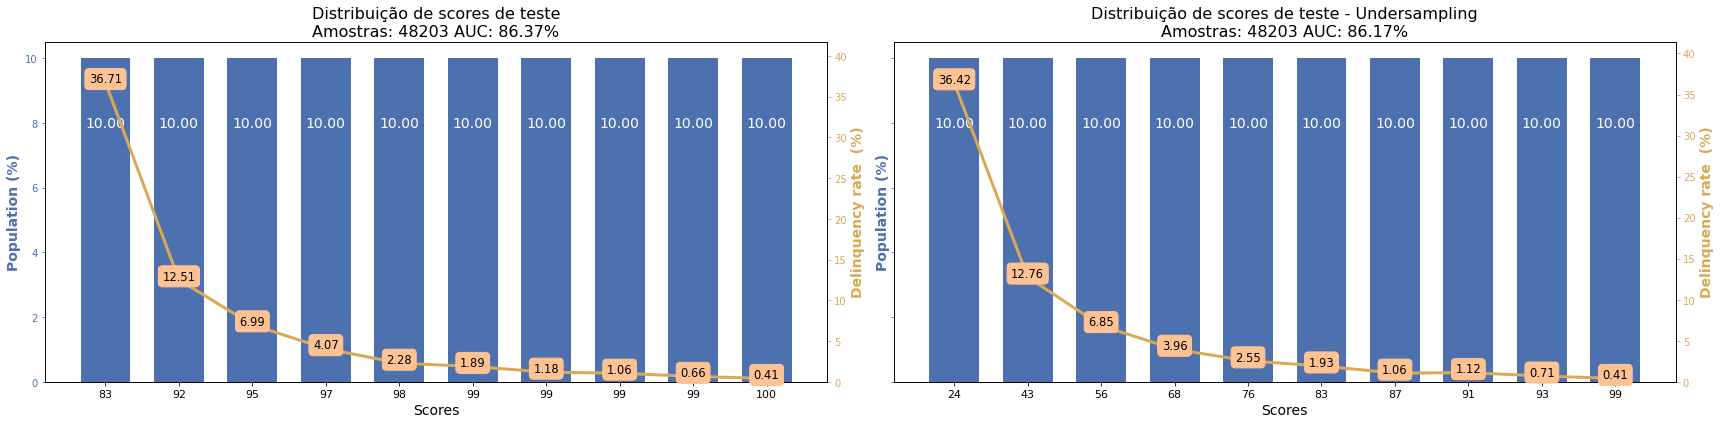

In [54]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred, y_test, buckets_as_quantiles=True).plot(ax=axis[0], title=title_test)
ScoreDistribution(y_pred_under, y_test, buckets_as_quantiles=True).plot(title_test_under, ax=axis[1])
plt.tight_layout()
plt.show()

# Meu modelo está pronto. E agora ?

- Transformar um sistem em um produto passa pela cultura DEVOPS

In [55]:
# save
file_name = 'xgboost_undersampling.pkl'
pickle.dump(final_model_under, open(file_name, "wb"))

In [ ]:
# load
file_name = 'xgboost_undersampling.pkl'
xgb_model_loaded = pickle.load(open(file_name, "rb"))